# Quantum Teleportation Demonstrator
### --- "now with (simulated) real quantum magic!"

# Overview

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state |𝜓⟩=𝛼|0⟩+𝛽|1⟩
. This entails passing on information about 𝛼 and 𝛽

to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of |𝜓⟩

and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state |𝜓⟩
to Bob. We call this teleportation as at the end Bob will have |𝜓⟩ and Alice won't anymore.

# The Quantum Teleportation Protocol

To transfer a quantum bit, Alice and Bob must use a third party (Eve) to send them an entangled qubit pair. Alice them performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

teleportation_doodle


We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [2]:
# Do the necessary imports
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
import math

qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

Initialize qubits and classical bits for Alice and Bob.

In [3]:
# Alice - two qubits, two classical bits
Alice_Psi = QuantumRegister(1)
Alice_Bell = QuantumRegister(1)
c_Alice_Psi = ClassicalRegister(1)
c_Alice_Bell = ClassicalRegister(1)

# Bob - one qubit, note: no classical bit
Bob_Bell = QuantumRegister(1)
c_Bob_Bell = ClassicalRegister(1)

In [4]:
# Initialize PSI with desired state
initial_vector = [
    math.sqrt(0.33) * complex(1, 0),
    math.sqrt(0.67) * complex(1, 0)
]
psi = initial_vector

In [5]:
# Initialize PSI with random state
# psi = random_state(1)

<IPython.core.display.Math object>

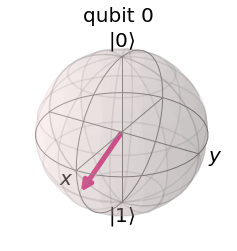

In [6]:
# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =") 

# Show it on a Bloch sphere
plot_bloch_multivector(psi)

### Let the teleportation begin

# Using statevector simulator

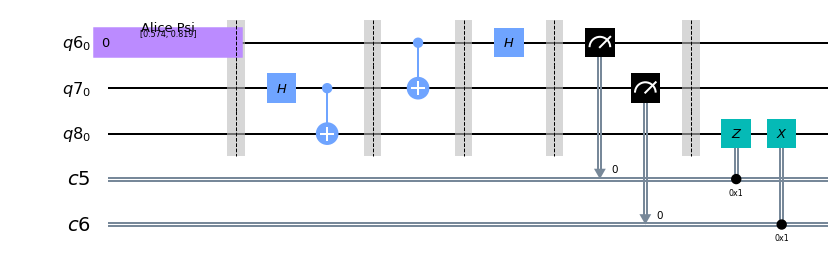

In [59]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Alice_Psi, c_Alice_Bell, name="teleportation")

# Prepare the initial state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice measures her qubits
qc.measure(Alice_Psi, c_Alice_Psi)
qc.measure(Alice_Bell, c_Alice_Bell)

# Transmit results on classical channel

qc.barrier()  # for better drawing

# Apply a correction at Bob
qc.z(Bob_Bell).c_if(c_Alice_Psi, 1)
qc.x(Bob_Bell).c_if(c_Alice_Bell, 1)

# Measure quantum state by Bob
# Note: do not measure by Bob, statevector_simulator instead
# qc.measure(q_b0, c_b0)

qc.draw()

Simulate the teleportation circuit with the statevector simulator 

<IPython.core.display.Math object>

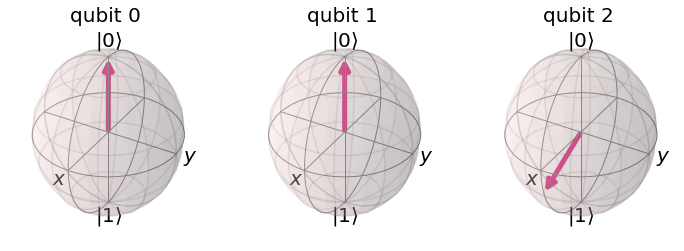

In [60]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()

# Teleported state
array_to_latex(out_vector, pretext="|\\psi\\rangle =") 
plot_bloch_multivector(out_vector)

# Using the QASM Simulator

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. You will remember that we used Initialize to turn our |0⟩
qubit into the state |𝜓⟩

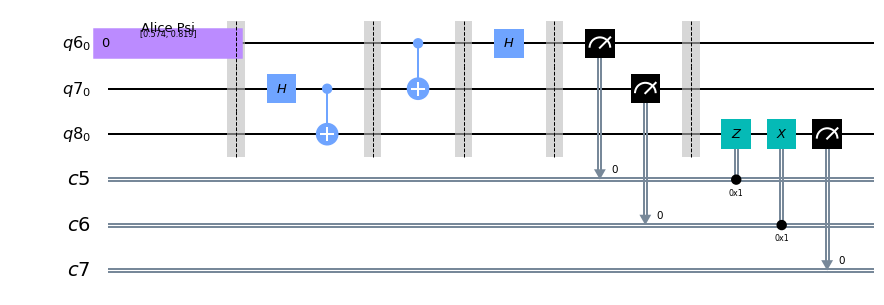

In [78]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Alice_Psi, c_Alice_Bell, c_Bob_Bell, name="teleportation")

# Prepare the initial state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice measures her qubits
qc.measure(Alice_Psi, c_Alice_Psi)
qc.measure(Alice_Bell, c_Alice_Bell)

# Transmit results on classical channel

qc.barrier()  # for better drawing

# Apply a correction at Bob
qc.z(Bob_Bell).c_if(c_Alice_Psi, 1)
qc.x(Bob_Bell).c_if(c_Alice_Bell, 1)

# Measure quantum state by Bob
qc.measure(Bob_Bell, c_Bob_Bell)

qc.draw()

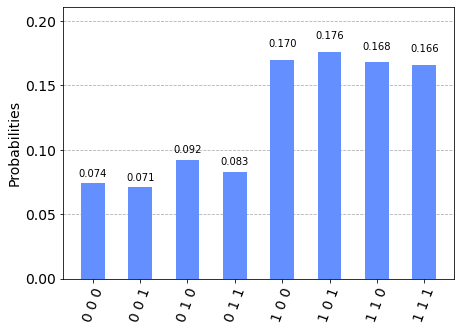

In [79]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

# Teleportation on a Real Quantum Computer

IBM hardware and Deferred Measurement

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the deferred measurement principle [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the bob_gates function to new_bob_gates:

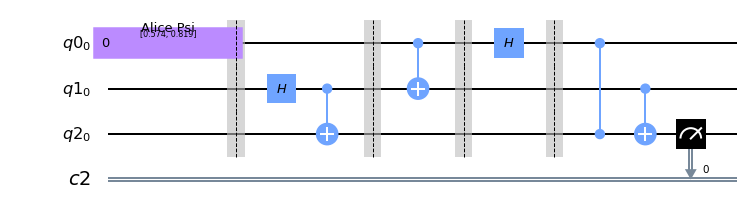

In [16]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Bob_Bell, name="teleportation")

# Prepare the initial state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice does not measure her qbits. Instead:
# Apply a delayed measurement at Bob
qc.cz(Alice_Psi, Bob_Bell)
qc.cx(Alice_Bell, Bob_Bell)

# Measure quantum state by Bob
qc.measure(Bob_Bell, c_Bob_Bell)

qc.draw()

In [9]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [12]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print ("Backend", backend)
job_exp = execute(qc, backend=backend, shots=8192)

Backend ibmqx2


{'1 0 0': 4949, '0 0 0': 3243}


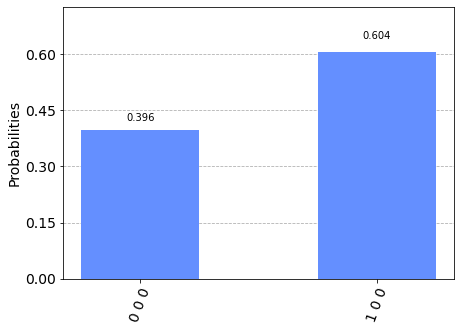

In [13]:
# Get the results and display them
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)